In [288]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import random


this PyTorch GAN model generate chinese number characters. 
```
{
  0: "十",
  1: "一",
  2: "二",
  3: "三",
  4: "四",
  5: "五",
  6: "六",
  7: "七",
  8: "八",
  9: "九",
}
```


In [321]:

train_images = []
totalImages = os.listdir( os.getcwd()+"/MNIST-CH")
 
for index in range(len(totalImages)):
    image = totalImages[index]
    if image.endswith(".jpg"):
        for n in range(10):
            train_images.append(image)

random.shuffle(train_images)

print(len(train_images))

2100


In [322]:

class MNIST_CH_Dataset(torch.utils.data.Dataset):
    def __init__(self,img_dir,images,transforms=None):
        self.img_dir = img_dir
        self.inputs = images
        self.transforms = transforms
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.inputs[idx])
        input = torchvision.io.read_image(img_path)
        if self.transforms:
            input = self.transforms(input)
        input = input.view(-1, 32)
       
        target =torch.tensor(int(self.inputs[idx].split('.')[-2][-1] ))
        return input,target
    
transform_train = transforms.Compose([
                                      transforms.RandomRotation(10),
                                      transforms.RandomCrop(32),
                                      # transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomAffine(0, translate=(0.1, 0.1)),
                                      transforms.ConvertImageDtype(dtype=torch.float32),
                                      transforms.Normalize(mean=(0.5,),
                                            std=(0.5,))
                                      ])

torch.Size([32, 32])
tensor([-1.0000, -0.9686, -1.0000, -0.9765, -1.0000, -0.9922, -1.0000, -1.0000,
        -1.0000, -0.9608, -1.0000, -0.9843, -1.0000, -1.0000, -0.7647, -0.4588,
         0.1373,  0.4039,  0.9373,  0.9686,  1.0000,  0.9686,  0.9922,  1.0000,
         0.6706, -0.9843, -1.0000, -1.0000, -0.9608, -1.0000, -0.9922, -1.0000]) tensor(1.) tensor(-1.) tensor(2)


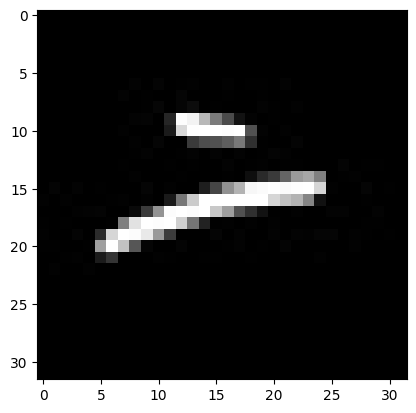

In [323]:
batch_size = 70

train_dataset = MNIST_CH_Dataset(img_dir=os.getcwd()+"/MNIST-CH",  images=train_images, transforms=transform_train )

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)


testInput,target = train_dataset.__getitem__(2)
print(testInput.shape)
print(testInput[15],testInput.max(),testInput.min(),target)
plt.imshow(testInput,cmap='gray')

In [324]:
discriminator = nn.Sequential(
    nn.Linear(1024, 784),
    nn.LeakyReLU(0.2),
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)

In [325]:
latent_dim = 60
generator = nn.Sequential(
    nn.Linear(latent_dim, 128),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(128, momentum=0.7),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    # nn.LeakyReLU(0.2),
    # nn.BatchNorm1d(1024, momentum=0.7),
    # nn.Linear(1024, 784),
    nn.Tanh()
)

In [326]:
criterion = nn.BCEWithLogitsLoss()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [327]:
def scale_image(img):
  out = (img + 1) / 2
  return out

In [330]:
ones_ = torch.ones(batch_size, 1)
zeros_ = torch.zeros(batch_size, 1)

# save losses
discriminator_losses = []
generator_losses = []
n_epochs = 500

for epoch in range(n_epochs):
  for inputs, _ in train_dataloader:
  
    n = inputs.size(0)
    inputs = inputs.reshape(n, 1024)
    
    ones = ones_[:n]
    zeros = zeros_[:n]
    
    # print(zeros.shape)
    
    # train discriminator 
    # real image from training dataset
    real_outputs = discriminator(inputs)
    discriminator_loss_real = criterion(real_outputs, ones)
    
    #  assume all generated images are fake
    noise = torch.randn(n, latent_dim)
    fake_images = generator(noise)
    fake_outputs = discriminator(fake_images)
    discriminator_loss_fake = criterion(fake_outputs, zeros)
    
    # gradient descent step
    d_loss = 0.5 * (discriminator_loss_real + discriminator_loss_fake)
    discriminator_optimizer.zero_grad()
    generator_optimizer.zero_grad()
    d_loss.backward()
    discriminator_optimizer.step()
    
    # train generator 
    for _ in range(2):
      noise = torch.randn(n, latent_dim)
      fake_images = generator(noise)
      
      fake_outputs = discriminator(fake_images)
     
      #  assume all generated images are true
      g_loss = criterion(fake_outputs, ones)
     
      # gradient descent step
      discriminator_optimizer.zero_grad()
      generator_optimizer.zero_grad()
      g_loss.backward()
      generator_optimizer.step()
      
    discriminator_losses.append(d_loss.item())
    generator_losses.append(g_loss.item())
  if (epoch + 1) % 10 == 0:
    print(f'Epoch {epoch+1}/{n_epochs}, discriminator Loss: {d_loss:.4f}, generator Loss: {g_loss:.4f}')
  if (epoch + 1) % 100 == 0:
    fake_images = fake_images.reshape(-1, 1, 32, 32)
    save_image(scale_image(fake_images), f"temp/{epoch + 1}.png")


Epoch 10/500, discriminator Loss: 0.6577, generator Loss: 0.7357
Epoch 20/500, discriminator Loss: 0.6679, generator Loss: 0.7806
Epoch 30/500, discriminator Loss: 0.6739, generator Loss: 0.6902
Epoch 40/500, discriminator Loss: 0.6605, generator Loss: 0.7854
Epoch 50/500, discriminator Loss: 0.6412, generator Loss: 0.7093
Epoch 60/500, discriminator Loss: 0.6746, generator Loss: 0.7254
Epoch 70/500, discriminator Loss: 0.6958, generator Loss: 0.7526
Epoch 80/500, discriminator Loss: 0.6674, generator Loss: 0.7391
Epoch 90/500, discriminator Loss: 0.6513, generator Loss: 0.9451
Epoch 100/500, discriminator Loss: 0.6526, generator Loss: 0.8211
Epoch 110/500, discriminator Loss: 0.6636, generator Loss: 0.9988
Epoch 120/500, discriminator Loss: 0.6956, generator Loss: 1.0005
Epoch 130/500, discriminator Loss: 0.6895, generator Loss: 0.8776
Epoch 140/500, discriminator Loss: 0.6310, generator Loss: 0.7996
Epoch 150/500, discriminator Loss: 0.6179, generator Loss: 0.6825
Epoch 160/500, disc

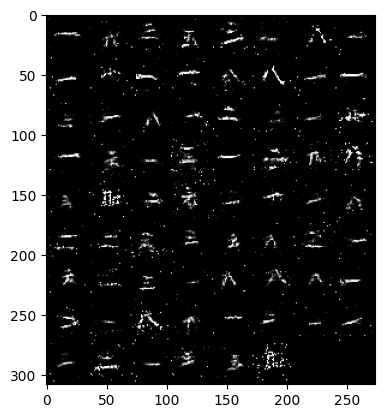

In [332]:
fake_images = generator(noise)
fake_images = fake_images.reshape(-1, 1, 32, 32)
save_image(scale_image(fake_images), f"temp/temp.png")

result_Image = torchvision.io.read_image(f"temp/temp.png")
plt.imshow(result_Image[0],cmap='gray')
# from skimage.io import imread
# a = imread('temp.png')
# plt.imshow(a)